In [16]:
import findspark
findspark.init()
from pyspark import SparkConf
from pyspark.sql import SQLContext, SparkSession,functions as F
from pyspark.sql.types import BinaryType, ArrayType, IntegerType, StringType
from pyspark.ml.linalg import Vectors, VectorUDT 
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
%matplotlib inline

In [2]:
sc = SparkSession.builder.master('local[*]')\
.appName("Test_image_pyspark")\
.config("spark.driver.memory", "2g")\
.getOrCreate()

#Launch & access SparkContext
spc = sc.sparkContext.getOrCreate()

### Getting path folder for our fruits sample and their labels

In [3]:
path = 'Images/fruits_images_samples/'
folder_fruits = os.listdir(path)
folder_fruits

['Cherry_Rainier', 'Apple_Red_1', 'Apple_Braeburn', 'Avocado', 'Cactus_fruit']

In [4]:
df_images = sc.read.format('image').load(f'{path}/*')
df_images.show()

+--------------------+
|               image|
+--------------------+
|[file:///home/yan...|
|[file:///home/yan...|
|[file:///home/yan...|
|[file:///home/yan...|
|[file:///home/yan...|
|[file:///home/yan...|
|[file:///home/yan...|
|[file:///home/yan...|
|[file:///home/yan...|
|[file:///home/yan...|
+--------------------+



In [7]:
df_images.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



### Let's get the dataframe in the format that we want, add path and label column and drop 'image' column'

In [5]:
# getting Image path with origin column
# getting some other information on the same level of column image
# getting image labels with the name of the folder, be carreful of [5] should be changed in function of the path
# getting data bytes of images
df_images = df_images.withColumn('image_path', F.split(F.col('image.origin'), 'file://')[1])\
.withColumn('height', F.col('image.height'))\
.withColumn('width', F.col('image.width')).withColumn('nChannels', F.col('image.nChannels'))\
.withColumn('label',(F.split((F.split(F.col('image.origin'), 'file://')[1]), '/'))[5])\
.withColumn('data', F.col('image.data'))
# droping image column
df_images = df_images.drop(F.col('image'))
# display the new dataframe with our images data
df_images.show()

+--------------------+------+-----+---------+--------------+--------------------+
|          image_path|height|width|nChannels|         label|                data|
+--------------------+------+-----+---------+--------------+--------------------+
|/home/yannick/Ima...|   100|  100|        3|   Apple_Red_1|[FF FD FF FF FD F...|
|/home/yannick/Ima...|   100|  100|        3|   Apple_Red_1|[FF FF FF FF FF F...|
|/home/yannick/Ima...|   100|  100|        3|Apple_Braeburn|[FF FF FE FF FF F...|
|/home/yannick/Ima...|   100|  100|        3|Cherry_Rainier|[FF FF F8 FF FF F...|
|/home/yannick/Ima...|   100|  100|        3|Apple_Braeburn|[FF FF FE FF FF F...|
|/home/yannick/Ima...|   100|  100|        3|Cherry_Rainier|[FF FE FF FF FE F...|
|/home/yannick/Ima...|   100|  100|        3|       Avocado|[FF FF FF FF FF F...|
|/home/yannick/Ima...|   100|  100|        3|       Avocado|[FF FF FF FF FF F...|
|/home/yannick/Ima...|   100|  100|        3|  Cactus_fruit|[FF FF FF FF FF F...|
|/home/yannick/I

In [6]:
df_images.printSchema()

root
 |-- image_path: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- width: integer (nullable = true)
 |-- nChannels: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- data: binary (nullable = true)



### Trying Image visualisations with DataFrame spark Object (use it only with samples data!!)

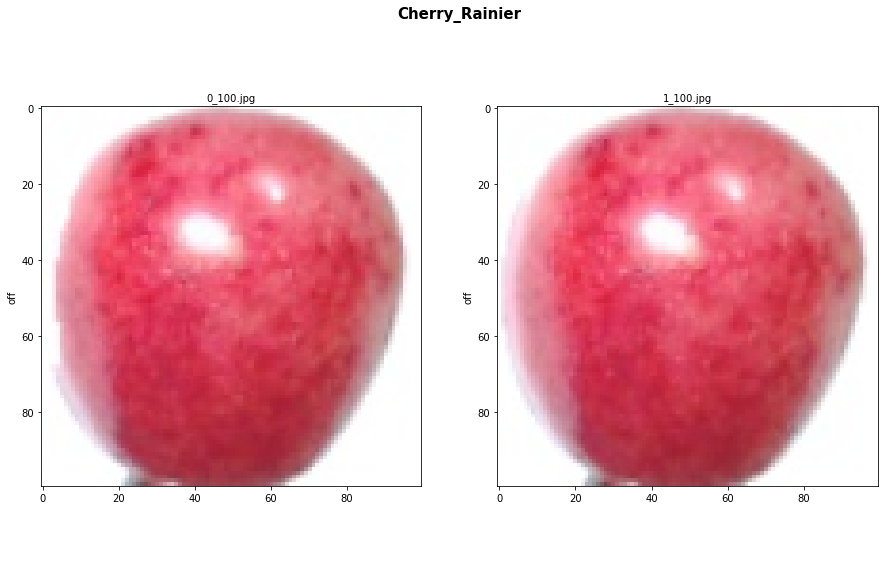

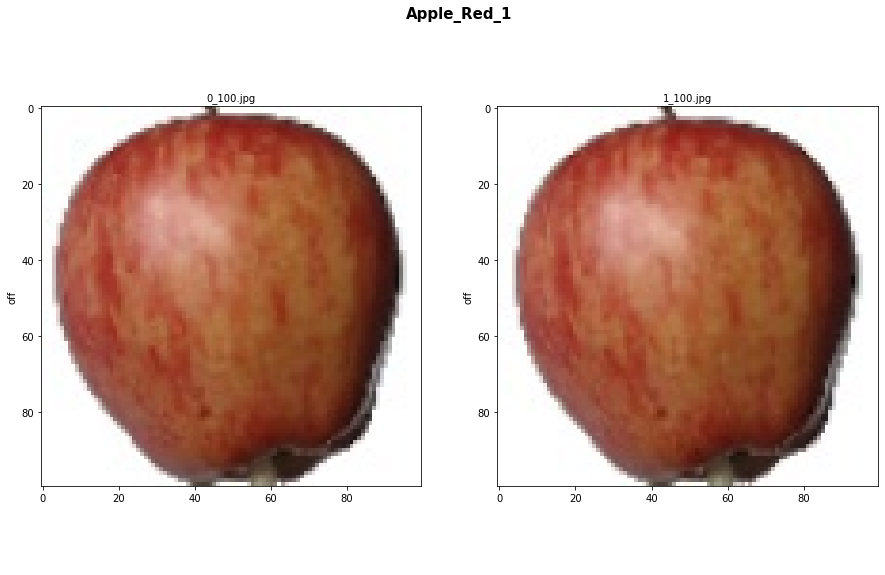

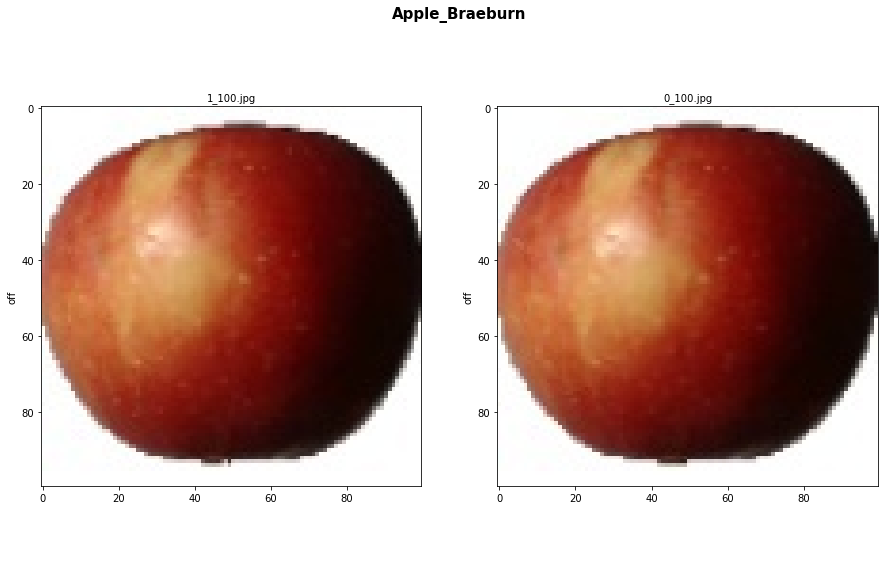

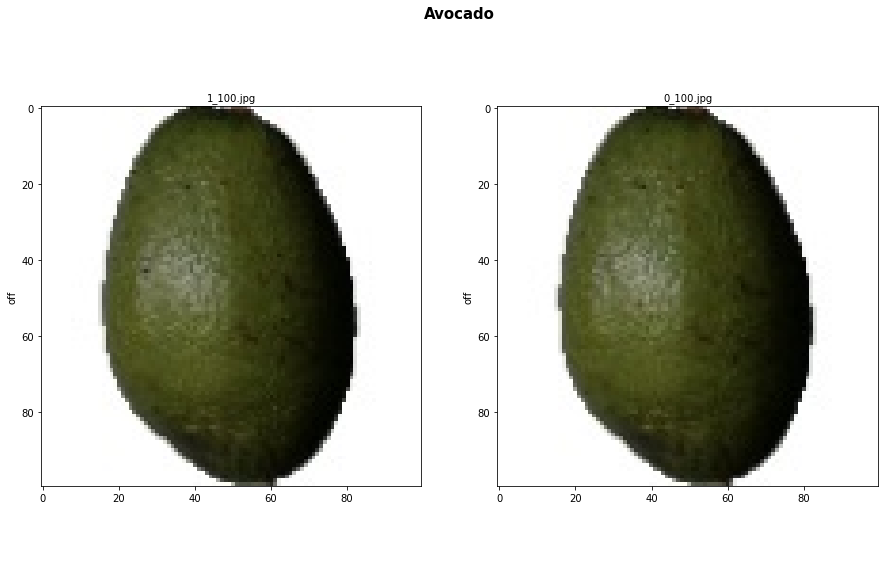

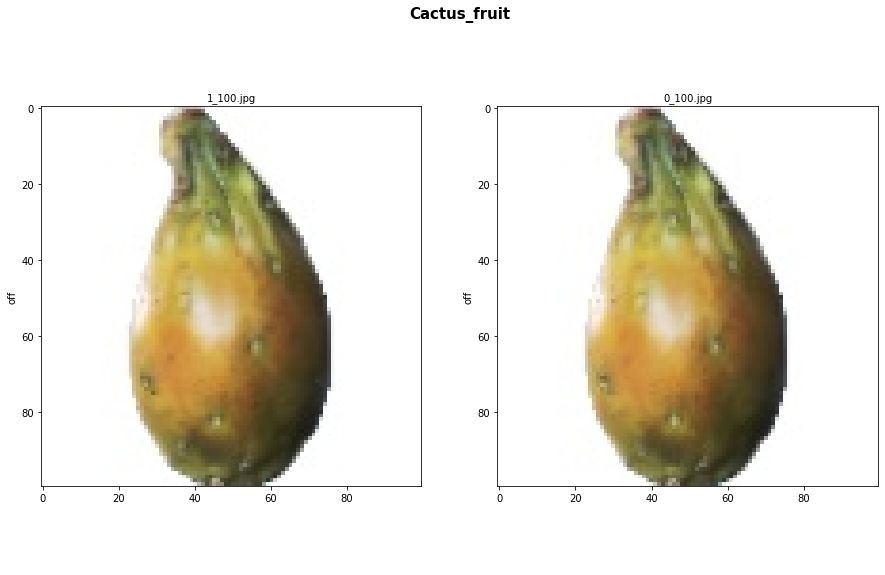

In [20]:
df_images_reduced = df_images.select('image_path','label', 'data')
# define each fruits available in our samples
for fruits in folder_fruits:
    # collect every rows in our filtered df and generate a figure
    title_fruits = fruits
    row_df = df_images_reduced.filter(F.col('label') == fruits).collect()
    figure_fruit = plt.figure(figsize=(15,10))
    plt.title(title_fruits, fontweight='bold', fontsize=15)
    plt.axis('off')
    # loop around rows collected
    count = 1
    for i in row_df:
        # define the title of image by is filename
        image_title = i[0].split('/')[-1]
        # convert bytetypes into an array of integer and reshape in image format
        image_array = np.array(i[2]).reshape(100,100,3)
        # getting image array from BGR to RGB channels for imshow function
        image_array_true_color = cv.cvtColor(image_array, cv.COLOR_BGR2RGB)
        # add images to our figure for one fruit
        figure_fruit.add_subplot(1,2,count)
        plt.title(image_title, fontsize=10)
        plt.ylabel('off')
        plt.imshow(image_array_true_color)
        count+=1
    plt.savefig(f'{fruits} images.jpg')
    plt.show()

### Perform preprocessing function with UDF and return new columns into the DataFrame

In [8]:
# function definition
def preprocess_images(data_bytes):
    '''Function to preprocess distribute image data with openCV
    we enter the image data from DataFrame Spark and return an array of integer to work with opencv on it
    The images are threated with blurrig and equalization function and resize in 32X32'''
    # getting data from image and pass it to img array shape
    img_data_bgr = np.array(data_bytes).reshape(100,100,3)
    # getting gray images
    img_data_gray = cv.cvtColor(img_data_bgr, cv.COLOR_BGR2GRAY)
    # Blurring
    img_data_gray = cv.GaussianBlur(img_data_gray, (3,3), 0)
    # Equalization
    img_data_gray = cv.equalizeHist(img_data_gray)
    # Resize
    img_data_gray = cv.resize(img_data_gray, (32,32))
    # flatten the result
    img_data_gray = img_data_gray.flatten()
    # forcing python list for the result instead of numpy array for spark to understand
    img_data_gray = img_data_gray.tolist()
    return img_data_gray

#UDF definition with returning array of integer for spark
udf_img_preprocess = F.udf(preprocess_images, ArrayType(IntegerType()))

In [9]:
# create column data_preprocess with flatten data
df_images = df_images.withColumn('preprocess_data',udf_img_preprocess(df_images.data))
df_images.show()

+--------------------+------+-----+---------+--------------+--------------------+--------------------+
|          image_path|height|width|nChannels|         label|                data|     preprocess_data|
+--------------------+------+-----+---------+--------------+--------------------+--------------------+
|/home/yannick/Ima...|   100|  100|        3|   Apple_Red_1|[FF FD FF FF FD F...|[255, 255, 228, 2...|
|/home/yannick/Ima...|   100|  100|        3|   Apple_Red_1|[FF FF FF FF FF F...|[255, 255, 255, 2...|
|/home/yannick/Ima...|   100|  100|        3|Apple_Braeburn|[FF FF FE FF FF F...|[255, 255, 247, 2...|
|/home/yannick/Ima...|   100|  100|        3|Cherry_Rainier|[FF FF F8 FF FF F...|[225, 225, 255, 2...|
|/home/yannick/Ima...|   100|  100|        3|Apple_Braeburn|[FF FF FE FF FF F...|[255, 255, 255, 2...|
|/home/yannick/Ima...|   100|  100|        3|Cherry_Rainier|[FF FE FF FF FE F...|[228, 255, 255, 2...|
|/home/yannick/Ima...|   100|  100|        3|       Avocado|[FF FF FF FF 

### Performing PCA with library ml

In [10]:
# transform our preprocess data to vector for PCA model via udf fonction to transform array into vector
to_vector = F.udf(lambda x: Vectors.dense(x), VectorUDT())

In [11]:
# creating vector column
df_images = df_images.withColumn('preprocess_data_vector', to_vector(df_images.preprocess_data))
df_images[['preprocess_data', 'preprocess_data_vector']].show(5)

+--------------------+----------------------+
|     preprocess_data|preprocess_data_vector|
+--------------------+----------------------+
|[255, 255, 228, 2...|  [255.0,255.0,228....|
|[255, 255, 255, 2...|  [255.0,255.0,255....|
|[255, 255, 247, 2...|  [255.0,255.0,247....|
|[225, 225, 255, 2...|  [225.0,225.0,255....|
|[255, 255, 255, 2...|  [255.0,255.0,255....|
+--------------------+----------------------+
only showing top 5 rows



In [13]:
# test with a few rows
df_images_reduced = df_images.limit(2)
df_images_reduced.show()

+--------------------+------+-----+---------+--------------+--------------------+--------------------+----------------------+
|          image_path|height|width|nChannels|         label|                data|     preprocess_data|preprocess_data_vector|
+--------------------+------+-----+---------+--------------+--------------------+--------------------+----------------------+
|/home/yannick/Ima...|   100|  100|        3|Apple_Braeburn|[FF FF FF FF FF F...|[255, 255, 255, 2...|  [255.0,255.0,255....|
|/home/yannick/Ima...|   100|  100|        3|Apple_Braeburn|[FF FF FF FF FF F...|[255, 255, 255, 2...|  [255.0,255.0,255....|
+--------------------+------+-----+---------+--------------+--------------------+--------------------+----------------------+



In [12]:
# performing PCA
k_number = 10
pca = PCA(k=k_number, inputCol="preprocess_data_vector")
pca.setOutputCol("pca_data_vector")
model = pca.fit(df_images)

In [13]:
df_PCA = model.transform(df_images)
df_PCA[['preprocess_data_vector', 'pca_data_vector']].show()
print('Explained_Variance_Ratio:', model.explainedVariance.sum())

+----------------------+--------------------+
|preprocess_data_vector|     pca_data_vector|
+----------------------+--------------------+
|  [255.0,255.0,228....|[-661.95527199896...|
|  [255.0,255.0,255....|[-682.96144962879...|
|  [255.0,255.0,247....|[-289.36356177605...|
|  [225.0,225.0,255....|[-1684.4265943424...|
|  [255.0,255.0,255....|[-276.34928556947...|
|  [228.0,255.0,255....|[-1654.2687498265...|
|  [255.0,255.0,255....|[-2686.0682303350...|
|  [255.0,255.0,255....|[-2710.1059529450...|
|  [255.0,255.0,255....|[-3746.6211286444...|
|  [255.0,255.0,255....|[-3731.0603346980...|
+----------------------+--------------------+

Explained_Variance_Ratio: 0.9999999999999826


### Saving files

#### Parquets

In [12]:
df_PCA.select('image_path', 'label', 'pca_data_vector').write.mode('overwrite')\
.parquet('Images/output/PCA_results_parquet')

#### CSV

In [13]:
# convert denseVector into string for saving in CSV, spark does'nt accept array vector format to save into csv
vector_to_string = F.udf(lambda x: str(x), StringType())
df_PCA = df_PCA.withColumn('pca_data_vector_str', vector_to_string(df_PCA.pca_data_vector))
# saving to CSV with column image_path, label and pca_vector_str
df_PCA.select('image_path', 'label', 'pca_data_vector_str').write.option("header", True).mode('overwrite')\
.csv('Images/output/PCA_results_CSV')